In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import pickle
import pyvista as pv


In [2]:
## Pyvista global settings
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')
pv.global_theme.transparent_background = False
pv.global_theme.show_scalar_bar = True
pv.start_xvfb()

In [3]:
## Import experimental results from Fox et al. 2018
with open('ExperimentalData.pkl','rb') as f:
    ExperimentalData = pickle.load(f)

In [4]:
## Import last time-step from LES model
folderName = r'/home/edsaa/nuModel/tempResults_review/refactored_dp9A.LES/VTK/'
fileName = r'refactored_dp9A.LES_23138487.vtk'
filePath = os.path.join(folderName,fileName)
LES = pv.read(filePath)

In [6]:
LES.set_active_scalars('depositedClay',preference='point')

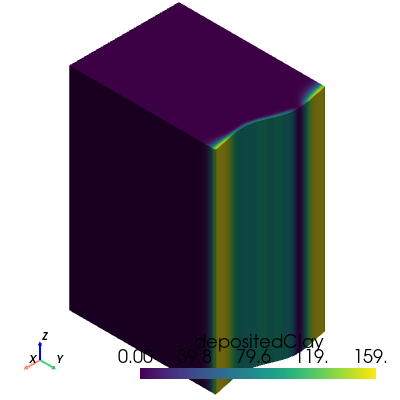

In [21]:
plotter = pv.Plotter(off_screen=False)
plotter.parallel_projection = True
plotter.add_mesh(LES)
plotter.add_axes()
plotter.show(window_size=[400,400],return_img=True)

In [22]:
## Clip to not show the deeper section
clipPoint  = (0,-0.05,0)

## Ignore the 3D and just plot a 2D slice
slicePoint = (0,0,0.15)

## Create a copy to show next to the original 
translatePoint = (0.15, 0, 0)

grid_A = LES.clip(normal='y',origin=clipPoint,invert=False).slice(normal='z',origin=slicePoint)
grid_B = grid_A.copy()
grid_B.translate(translatePoint,inplace=True)
for g in [grid_A,grid_B]: g.set_active_scalars('depositedClay',preference='point')

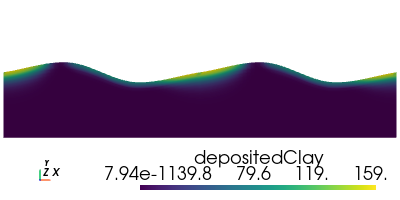

In [23]:
plotter = pv.Plotter(off_screen=False)
plotter.parallel_projection = True
plotter.add_mesh(grid_A)
plotter.add_mesh(grid_B)
plotter.add_axes()
plotter.camera_position = 'xy'
plotter.camera.zoom(2.0)
plotter.show(window_size=[400,200],return_img=True)

In [24]:
# Create planes at the core locations
z = slicePoint[2] - 0.01
cores_planes = [[pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.10,0.13]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.14,0.17]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.18,0.21]],
                [pv.Line((x,-0.05,z),(x,0.02,z)) for x in [0.22,0.25]]]

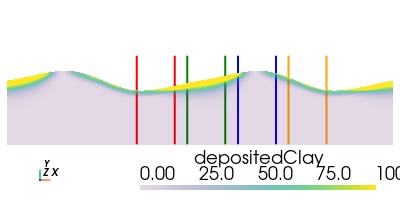

In [28]:
CLIM = [0.0,100]
CMAP = 'viridis'
NCOL = 128

# Initialize plotter
plotter = pv.Plotter(off_screen=False)
plotter.parallel_projection = False
kw_add_mesh = dict(scalars='depositedClay',n_colors=NCOL,cmap=CMAP,clim=CLIM,\
                   opacity=[0.15,1.0],use_transparency=False,lighting=False,ambient=0)

# Add information to plotter
plotter.add_mesh(grid_A,**kw_add_mesh)
plotter.add_mesh(grid_B,**kw_add_mesh)
plotter.add_axes()

## Plot lines of cores
cores_id = ['Core A','Core B','Core C','Core D']
core_color = ['r','g','b','orange']

for core,color in zip(cores_planes,core_color):
    for line in core:
        plotter.add_mesh(line,color=color,line_width=2)

plotter.camera_position = 'xy'
plotter.camera.zoom(2.0)
plotter.show(window_size=[400,200],return_img=True)

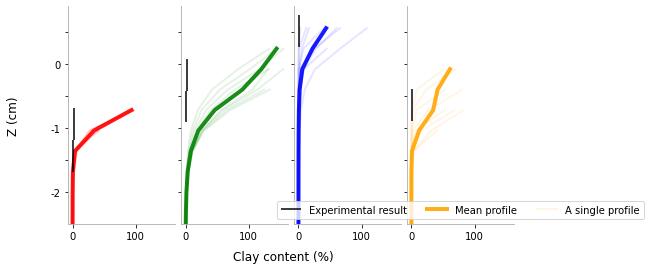

In [29]:
resx = 8
cores_x = [np.linspace(0.10,0.13,resx),
           np.concatenate((np.linspace(0.14,0.15,4),np.linspace(0.01,0.02,4))),
           np.linspace(0.03,0.06,resx),
           np.linspace(0.07,0.10,resx)]

fig,axs = plt.subplots(1,4,sharey=True,sharex=True,gridspec_kw={'wspace':0.05},figsize=[8,4])

for i,core in enumerate(cores_x):
    pC_accum,y_accum = [],[]
    for x in core:
        line_bottom,line_top = (x,-0.10,0.145),(x, 0.06,0.145)
        samples = LES.sample_over_line(line_top,line_bottom,resolution=50)
        pC = np.ma.masked_where(samples['vtkValidPointMask']<1.0,samples['depositedClay'])
        #pC *= 100
        y  = np.ma.masked_where(samples['vtkValidPointMask']<1.0,samples.points[:,1])
        pC_accum.append(pC)
        y_accum.append(y)
        littleLine = axs[i].plot(pC,y,color=core_color[i],alpha=0.1,lw=2,zorder=1)
        
    pC_accum = np.ma.stack(pC_accum,axis=0)
    meanPc = pC_accum.mean(axis=0)
    y_accum = np.ma.stack(y_accum,axis=0)
    meanY = y_accum.mean(axis=0)
    #axs[i].plot(meanPc,meanY,color='k',alpha=0.9,lw=2,ls='-')
    bigLine = axs[i].plot(meanPc,meanY,color=core_color[i],alpha=0.9,lw=4,ls='-',zorder=3)
    
    #stdPc = pC_accum.std(axis=0)
    #axs[i].plot(meanPc+stdPc,meanY,color=core_color[i],alpha=0.9,lw=2,ls='-')
    #axs[i].plot(meanPc-stdPc,meanY,color=core_color[i],alpha=0.9,lw=2,ls='-')

for ax in axs: 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('darkgray')
    ax.spines['bottom'].set_color('darkgray')
    
axs[0].set_ylim([-0.025,0.009])
#axs[0].set_xlim([-0.4,5.0])
axs[0].set_yticks([0.005,0,-0.005,-0.01,-0.015,-0.02])
axs[0].set_yticklabels(['','0','','-1','','-2'])

fig.supxlabel('Clay content (%)',y=-0.01)
fig.supylabel('Z (cm)')

## Measurements
experiment = ExperimentalData['Neutral']
ycores = ExperimentalData['Y']
ccores = ExperimentalData['Neutral']['C']
scores = ExperimentalData['Neutral']['std']

for y,cv,sv,ax in zip(ycores,ccores,scores,axs):
    dy = 0.5E-2
    y1 = y
    y2 = y - dy
    for c,s in zip(cv,sv):
        linecollection = ax.vlines(c,y2,y1,colors='k',zorder=4)
        ym = (y1+y2)/2
        ax.hlines(ym,c-s,c+s,colors='k',zorder=4)
        y1 -= dy
        y2 -= dy

axs[-1].legend([linecollection]+bigLine+littleLine,
               ['Experimental result','Mean profile','A single profile'],
               loc='lower center',ncol=3)
#plt.savefig("ProfilingLES.svg")
plt.show()